# Introduction to Coba
Coba is a Python package built to research contextual bandit (CB) algorithms.

Coba is organized around five core concepts:

1. **Environments**: Sequences of interactions defined by contexts, actions and rewards.
2. **Learners**: Algorithms that make decisions and learn from the generated reward.
3. **Evaluators**: Steps to train and evaluate Learners for a given Environment.
4. **Experiments**: Collections of Environments, Learners, and Evaluators that produce Results.
5. **Results**: The data produced by an Experiment when evaluating.

The general Coba workflow is: 1) create or select the environments to use for evaluation, 2) select the Learners to evaluate,  3) create an experiment using the selected learners and environments, and 4) run the experiment and analyze the results. In what follows we will walk through this workflow and see how to use many of the learners and environments provided by Coba out-of-the-box. 

## First Coba Experiment
### Selecting Environments
Every experiment in Coba begins by selecting the environments to use for learner evaluation. Coba provides a high level **Environments** API to easily create and modify environments. For this example we will use this API to create a basic linear environment. We then apply a **Binary** filter to it so that for each interaction the action with the highest reward has a reward value of 1 while all other actions have a reward of 0. This will be useful for interpretation later on.

In [1]:
import coba as cb
environments = cb.Environments.from_linear_synthetic(500).binary()

### Selecting Learners
Next an experiment needs some learners to evaluate. Coba comes with a number of existing learners. We're going to pick three:
1. **RandomLearner**: This learner randomly selects actions. It is useful as a comparison to make sure learners are actually "learning".
2. **EpsilonBanditLearner**: This learner follows an epsilon greedy policy and calculates the mean reward for each action.
3. **VowpalEpsilonLearner**: This learner follows an epsilon greedy policy and uses a linear regressor to predict expected reward.

### Running the Experiment
Using the selected environments and learners we can create and run an Experiment. 

Coba Experiments take care of all the work of actually evaluating our learners against our environments and creating Results. 

Creating and running our experiment looks like this:

In [2]:
import coba as cb

env = cb.Environments.from_linear_synthetic(2000,seed=2).binary()
lrn = [cb.VowpalEpsilonLearner(),cb.EpsilonBanditLearner(),cb.RandomLearner()]
res = cb.Experiment(env,lrn).run()

2024-01-14 17:07:35 -- Experiment Started
2024-01-14 17:07:35 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:35 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:35 -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:35 -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:35 -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-01-14 17:07:35 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:35 -- Peeking at Environment 0... (0.01 seconds) (completed)
2024-01-14 17:07:36 -- Evaluating Learner 0 on Environment 0... (0.8 seconds) (completed)
2024-01-14 17:07:36 -- Peeking at Environment 0... (0.02 seconds) (completed)
2024-01-14 17:07:36 -- Evaluating Learner 1 on Environment 0... (0.47 seconds) (completed)
2024-01-14 17:07:36 -- Peeking at Environment 0... (0.02 seconds) (completed)
2024-01-14 17:07:37 -- Evaluating Learner 2 o

-------------
And just like that we've run our first experiment in Coba. We can now create a summary plot using our results to see what happened.

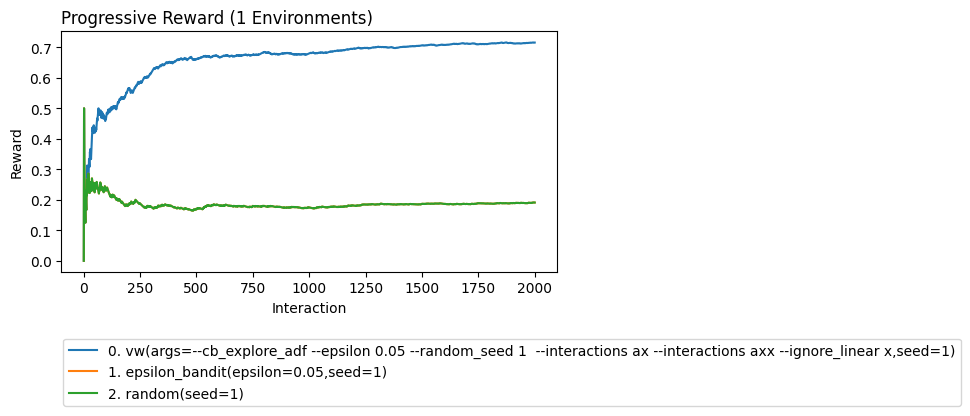

In [3]:
res.plot_learners()

Taking a quick moment to explain the plot, the x-axis indicates how many times our learners have interacted with the environment. The y-axis indicates the average reward received since the beginning of the Experiment. And the legend below the plot shows each learner and their hyperparameters.

Of course, running a single experiment often leads to more questions. Where is the **EpsilonBanditLearner**? In this case it is immediately beneath **RandomLearner**. There are a few reasons for why this happened so let's see if we can't figure this out by running a second experiment.

## Second Coba Experiment
As we mentioned above bandit learners don't consider context or action features when choosing actions. For our second experiment then we're going to modify the **LinearSyntheticSimulation** to see what parameters are causing this strange behavior. Look at the new code and notice the new parameter `n_action_features=0`.

2024-01-14 17:07:48 -- Experiment Started
2024-01-14 17:07:48 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:48 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:48 -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:48 -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:48 -- Peeking at Environment 0... (0.01 seconds) (completed)
2024-01-14 17:07:48 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-01-14 17:07:48 -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-01-14 17:07:49 -- Evaluating Learner 0 on Environment 0... (0.51 seconds) (completed)
2024-01-14 17:07:49 -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-01-14 17:07:49 -- Evaluating Learner 1 on Environment 0... (0.18 seconds) (completed)
2024-01-14 17:07:49 -- Peeking at Environment 0... (0.01 seconds) (completed)
2024-01-14 17:07:49 -- Evaluating Learner 2 o

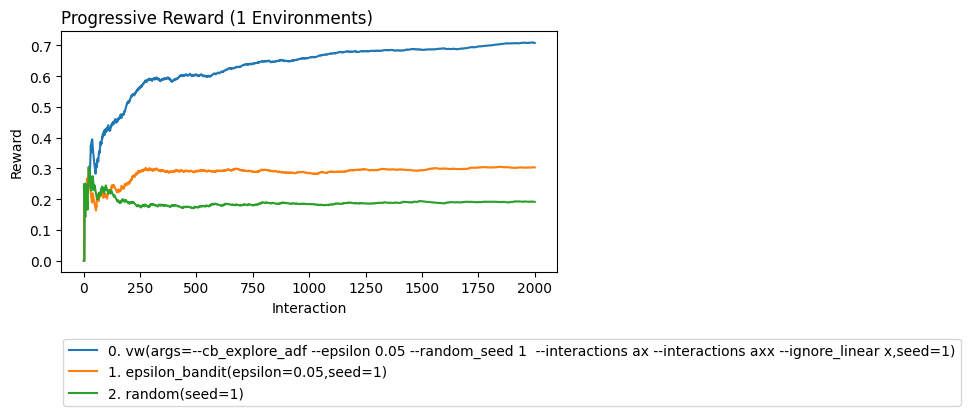

In [4]:
import coba as cb

environments = cb.Environments.from_linear_synthetic(2000,n_action_features=0,seed=2).binary()
learners     = [ cb.VowpalEpsilonLearner(), cb.EpsilonBanditLearner(), cb.RandomLearner()]

cb.Experiment(environments, learners).run().plot_learners()

Look at that! **EpsilonBanditLearner** and **RandomLearner** are no longer identical. So what happened? 

When we set `n_action_features=0` this changed the **LinearSyntheticSimulation** so that its actions no longer had "features". To understand what this means it helps to consider an example where we want to recommended a movie. Our actions in this case would be movies and each movie may have certain features that helps us decide what to recommend like its genre or critic rating. When our actions don't have features the environment is more like recommending an activity such as reading, watching a movie or going for a walk than a movie. That is, each action is distinguishable without needing features to describe it. Why do you think this changed the performance of **EpsilonBanditLearner**?

Ok, time for one final experiment. Let's see if we can get **EpsilonBanditLearner** performing competitively.

## One Final Experiment
For this final experiment we're going to make several changes to the **LinearSyntheticSimulation**.

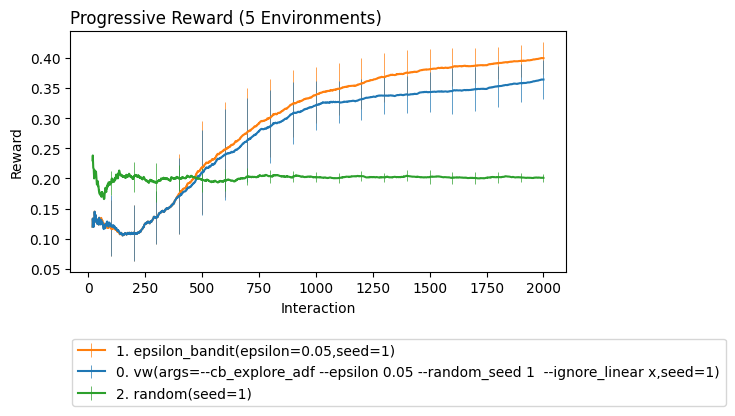

In [6]:
import coba as cb

base_environment = cb.Environments.from_linear_synthetic(2000, n_context_features=0, n_action_features=0)

environments = base_environment.noise(reward=lambda rwd,rng:rwd+rng.gauss(0,.5)).binary().shuffle([1,2,3,4,5])
learners     = [cb.VowpalEpsilonLearner(features=[1,'a']), cb.EpsilonBanditLearner(), cb.RandomLearner() ]

result = cb.Experiment(environments, learners).run(quiet=True)
result.plot_learners(err='se',xlim=(20,2000))

Wow, there was a lot more output that time. We'll come back to that in a second but first, look at that plot. Our underdog, **EpsilonBanditLearner** is finally hanging with the big boys. With context_features and action_features turned off we're now evaluating against a multi-armed bandit simulation. This is actually what bandit algorithms are designed for and sure enough we can see **EpsilonBanditLearner** performs well in this simulation. 

What are those new lines, though, on the plot? Those weren't there before. Those are there because we specified `shuffle`. In fact, the reason there was so much more output with this experiment is because of `shuffle`. Applying shuffle to **Environments**  makes `n` environments (where `n` is the length of the `shuffle` list). This means there is also `n` times more output to log as we process each environment.

In [4]:
environments

1. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'binary': True},{'shuffle': 1}
2. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'binary': True},{'shuffle': 2}
3. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'binary': True},{'shuffle': 3}
4. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'binary': True},{'shuffle': 4}
5. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'binary': True},{'shuffle': 5}


## Conclusion
We hope this brief introduction has gotten you excited about the possibilities of COBA. What would you like to do first with Coba? Do you have an algorithm that you're hoping to publish and would like to easily test against other learners? Do you have a data set that you'd like to build a simulation from to see which contextual bandit algorithm performs best on it? Or are you just trying to learn more about machine learning and are just looking for an easy way to test introductory algorithms while you learn? All the above are easy to do with Coba. 

We also welcome code contributions for new features. Feel free to reach out to mr2an@virginia.edu for ideas about features that Coba could benefit from. Coba is able to do a lot more than what we've shown here. It has its own environment syntax to allow you to define environments in a separate file for easy sharing. It is also able to import environments from a number of data formats. It is able to manage resource constraints to maximize through put of long running environments. And it can download remote data sets. All of this functionality has grown out of our own experimental needs and so we hope most of what we've built will be useful to others.